In [25]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
import cv2
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense

from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from time import time

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
# load dataset

# sur colab
# TRAIN_IMAGES_PATH = "F:/Projet_computer_vision/plant-pathology-2021-fgvc8/train_images/"

# en local
TRAIN_IMAGES_PATH = "F:/Projet_computer_vision/plant-pathology-2021-fgvc8/compressed/train_images/"
TEST_IMAGES_PATH = "F:/Projet_computer_vision/plant-pathology-2021-fgvc8/test_images/"
# sur colab
TRAIN_PATH = "F:/Projet_computer_vision/plant-pathology-2021-fgvc8/train.csv"
# en local
TRAIN_PATH = "F:/Projet_computer_vision/plant-pathology-2021-fgvc8/compressed/train_comp.csv"
SUB_PATH = "F:/Projet_computer_vision/plant-pathology-2021-fgvc8/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
# test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)
# print(train_data[:5])
test_data = pd.read_csv(SUB_PATH)
# print(test_data)

# bon 3
classes=set()
for v in train_data["labels"].values:
    classes.update(set(v.split()))
print("classes= ", classes)

#On peut associer les images des feuilles à 5 classes possibles:
#'complex', 'frog_eye_leaf_spot', 'powdery_mildew', 'rust', 'scab'
# healthy , quand aucune de ces classes n'est là.

# train_data['healthy']=train_data['labels'].apply(lambda x: 1 if 'healthy' in x else 0) 
train_data['scab']=train_data['labels'].apply(lambda x: 1 if 'scab' in x else 0) 
train_data['rust']=train_data['labels'].apply(lambda x: 1 if 'rust' in x else 0) 
train_data['powdery_mildew']=train_data['labels'].apply(lambda x: 1 if 'powdery_mildew' in x else 0) 
train_data['frog_eye_leaf_spot']=train_data['labels'].apply(lambda x: 1 if 'frog_eye_leaf_spot' in x else 0) 
train_data['complex']=train_data['labels'].apply(lambda x: 1 if 'complex' in x else 0) 
train_data
print(train_data[:3])

# en local 
def add_path_compressed_train(file):
    return TRAIN_IMAGES_PATH  + file

def add_path_test(file):
    return TEST_IMAGES_PATH + file


train_files= train_data.image.map(add_path_compressed_train).values
print(train_files[:3])

test_files= test_data.image.map(add_path_test).values
print(test_files)

labels = np.float32(train_data.loc[:, 'scab':'complex'].values)
print("labels= ", labels[:3])

print("shapes= ", train_files.shape, labels.shape,)

classes=  {'powdery_mildew', 'complex', 'frog_eye_leaf_spot', 'rust', 'healthy', 'scab'}
                             image                           labels  scab  \
0  Compressed_800113bb65efe69e.jpg                          healthy     0   
1  Compressed_8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex     1   
2  Compressed_80070f7fb5e2ccaa.jpg                             scab     1   

   rust  powdery_mildew  frog_eye_leaf_spot  complex  
0     0               0                   0        0  
1     0               0                   1        1  
2     0               0                   0        0  
['F:/Projet_computer_vision/plant-pathology-2021-fgvc8/compressed/train_images/Compressed_800113bb65efe69e.jpg'
 'F:/Projet_computer_vision/plant-pathology-2021-fgvc8/compressed/train_images/Compressed_8002cb321f8bfcdf.jpg'
 'F:/Projet_computer_vision/plant-pathology-2021-fgvc8/compressed/train_images/Compressed_80070f7fb5e2ccaa.jpg']
['F:/Projet_computer_vision/plant-pathology-2

In [75]:
type(train_files)

numpy.ndarray

In [27]:
def decode_image(filename,label=None,  image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label
    
def make_dataset(train_images, train_labels, valid_images, valid_labels, test_files, image_size,batch_size):
    
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((train_images, train_labels))   
        #.from_tensor_slices((train_images[:10], train_labels[:10]))   
        .map(tf.autograph.experimental.do_not_convert(lambda x,y: decode_image(x,y, image_size)), num_parallel_calls=AUTO )           
        #.map(decode_image, num_parallel_calls=AUTO)
        .map(data_augment, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(512)
        .batch(batch_size)
        .prefetch(AUTO)
    )
    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((valid_images, valid_labels))
        # .from_tensor_slices((valid_images[:2], valid_labels[:2]))
        # .map(decode_image, num_parallel_calls=AUTO)
        .map(tf.autograph.experimental.do_not_convert(lambda x,y: decode_image(x,y, image_size)), num_parallel_calls=AUTO )           
        .batch(batch_size)
        .cache()
        .prefetch(AUTO)
    )
    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(test_files)
        .map(tf.autograph.experimental.do_not_convert(lambda x: decode_image(x,None, image_size)), num_parallel_calls=AUTO )           
        .batch(batch_size)
    )
    return train_dataset,valid_dataset,test_dataset


        

# def get_model(image_shape):
#     # InRes3
#     #Adding the final layers to the above base models where the actual classification is done in the dense layers
#     InResNetV2= InceptionResNetV2(include_top=False, weights="imagenet", \
#         input_tensor=None, input_shape=image_shape, pooling='avg') 
#     model_InResNet2 = Sequential()
#     model_InResNet2.add(InResNetV2)
#     model_InResNet2.add(Dense(5, activation=('sigmoid')))

#     model_InResNet2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#     model_InResNet2.summary()
#     return model_InResNet2

def get_model(image_shape):
    # InRes3
    #Adding the final layers to the above base models where the actual classification is done in the dense layers
    InResNetV2= InceptionResNetV2(include_top=False, weights="imagenet", \
        input_tensor=None, input_shape=image_shape, pooling='avg') 
    model_InResNet2 = Sequential()
    model_InResNet2.add(InResNetV2)
    model_InResNet2.add(Dense(5, activation=('sigmoid')))

    model_InResNet2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model_InResNet2.summary()
    return model_InResNet2



def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    # lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn   


def train(model, train_dataset, valid_dataset,epochs, len_train,  batch_size, filenum):
         
    
    # learning rate
    lrfn = build_lrfn()
    STEPS_PER_EPOCH = len_train // batch_size
    # STEPS_PER_EPOCH = 10
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
    
    # Early Stopping
    early_stop= EarlyStopping(monitor='val_accuracy',patience=5, mode='max' )
    
    # save the weights given the best val_loss
    filepath='F:/Projet_computer_vision/bons_hdf5_plant/ResNet50-best-dataset-062021-'+str(filenum)+'.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    # callbacks_list = [lr_schedule,checkpoint ]
    callbacks_list = [lr_schedule,early_stop, checkpoint ]
    
    Network=model.fit(train_dataset, steps_per_epoch=STEPS_PER_EPOCH, verbose=1, \
                            validation_data=valid_dataset,callbacks=callbacks_list,epochs=epochs)
    
    return Network
    
    
def validate(model, valid_dataset,len_valid,n):    # exactement : accuracy_score(valid_true_labels, np.round(valid_pred)) de sklearn
   
    # batch_size= 16
    # transforme le dataset des labels de validation en numpy ndarray 
    def pre_validation(valid_dataset):

        valid_true_labels=np.zeros((len_valid,5))

        for i, x in enumerate(valid_dataset):           
                for  j in range(16):
                    if j + 16 * i  < len_valid:                       
                        valid_true_labels[j+ 16 * i]= x[1][j]            
                     # print(i)
                    else:
                        break;               

        return valid_true_labels
    
    valid_true_labels=  pre_validation(valid_dataset)
    
    model = load_model("F:/Projet_computer_vision/bons_hdf5_plant/ResNet50-best-dataset-062021-"+str(n)+".hdf5")
    valid_pred = model.predict(valid_dataset)
    
    # c'est exactement : accuracy_score(valid_true_labels, np.round(valid_pred)) (from sklearn.metrics import accuracy_score)
    accuracy= np.mean(np.all(valid_true_labels == np.round(valid_pred), axis=1))
    
    return accuracy

# une autre manière pour calculer la validation accuracy qui donne le même résultat.
def validate1(model, valid_dataset,len_valid,n): 
   
    def pre_validation(valid_dataset):

        valid_true_labels=np.zeros((len_valid,5))

        for i, x in enumerate(valid_dataset):           
                for  j in range(16):
                    if j + 16 * i  < len_valid:
                        
                        valid_true_labels[j+ 16 * i]= x[1][j]            
                    
                    else:
                        break;               

        return valid_true_labels
    
    valid_true_labels=  pre_validation(valid_dataset)
    
    
    valid_pred = model.predict(valid_dataset)
    accuracy_score(valid_true_labels, np.round(valid_pred))
    
    return accuracy

# fonction qui trace les 2 courbes loss et validation loss ainsi que l'accuracy et la validation accuracy
def loss_accuracy_curves(Network) :
    plt.subplot(121)
    plt.plot(Network.history['loss'],label='Train')
    plt.plot(Network.history['val_loss'],label='Validation')
    plt.ylabel('Loss',fontsize=20)
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'], loc='best')  # upper

    plt.subplot(122)
    plt.plot(Network.history['accuracy'],label='Train')
    plt.plot(Network.history['val_accuracy'],label='Validation')
    plt.ylabel('Accuracy',fontsize=20)
    plt.xlabel('epoch')
    plt.legend(['Training', 'Validation'], loc='best')  # upper
    plt.tight_layout()

    plt.show()
    
    

In [67]:
train_files.shape

(18632,)

In [70]:
labels.shape

(18632, 5)

In [56]:
image_size=(100, 100)
AUTO = tf.data.experimental.AUTOTUNE
batch_size =16

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

debut= time()

train_images, valid_images, train_labels, valid_labels =\
        train_test_split(train_files, labels, test_size=0.15, random_state=2021)

len_train = train_images.shape[0] 
len_valid=valid_images.shape[0]
        
print(len_train, len_valid)
        
print("Création des datasets train, validation et test")
train_dataset,valid_dataset,test_dataset= make_dataset(train_images, train_labels, valid_images, valid_labels, test_files,\
                                                               image_size, batch_size)
                
print("Création du modèle à partir d'une Keras application (deep learning pre-trained models")
print("https://keras.io/api/applications/ ")
        
image_shape = image_size + (3,) 
model= get_model(image_shape)
        
print("training")
# training du modèle et sauvegarde du meilleur modèle (max val_accuracy) rencontré lors des epochs (sauvegarde des poids)
Network= train(model, train_dataset, valid_dataset,epochs=10, len_train=len_train, batch_size=16, filenum=1)



# faire une prediction du validation set à partir du modèle et la comparer aux vrais labels
# ça équivaut à un accuracy_score de sklearn.
# attention : c'est pas équivalent au model.evaluate(valid_dataset) de keras, ça ne donne pas les mêmes résultats car 
# il s'agit d'une classification Multi-Class et multi-label.

print("validation")
val_accuracy = validate(model, valid_dataset,len_valid)

# Sauvegarde de la val_accuracy dans uen liste pour un calcul de moyenne et d'écart-type
print('>>>>>>>>>>>>>>>>>>>>>>>>>>> validation_accuracy %.3f' % val_accuracy)

duree_totale = time()- debut
print("durée du training (en secondes) =", duree_totale)

15837 2795
Création des datasets train, validation et test
Création du modèle à partir d'une Keras application (deep learning pre-trained models
https://keras.io/api/applications/ 
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 7685      
Total params: 54,344,421
Trainable params: 54,283,877
Non-trainable params: 60,544
_________________________________________________________________
training
Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
989/989 [==============================] - 2960s 3s/step - loss: 0.6075 - accuracy: 0.2251 - val_loss: 8864.2354 - val_accuracy: 0.5989
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-

In [57]:
valid_pred = model.predict(valid_dataset)
valid_pred

array([[9.60115135e-01, 3.03328037e-04, 9.00566578e-04, 1.23788118e-02,
        8.18437338e-03],
       [1.00664198e-02, 1.20529532e-03, 3.36247683e-03, 1.73284709e-02,
        1.64461136e-03],
       [1.39792889e-01, 9.37607408e-01, 4.02294754e-05, 3.13884616e-02,
        1.20307803e-02],
       ...,
       [5.20948946e-01, 2.63401866e-03, 4.04312015e-02, 6.43036962e-01,
        9.09491658e-01],
       [5.99010587e-01, 4.83632088e-03, 1.10037625e-02, 3.88025045e-02,
        2.77595043e-01],
       [1.18404418e-01, 1.85294675e-06, 1.81166261e-01, 7.40766525e-04,
        8.17588516e-05]], dtype=float32)

In [53]:
score=model.evaluate(valid_dataset, verbose=2)

# Get the accuracu metric
print(model.metrics_names[0],'=',score[0])
print(model.metrics_names[1],'=',score[1])

175/175 - 41s - loss: 0.7054 - accuracy: 0.1052
loss = 0.7053700685501099
accuracy = 0.10518783330917358


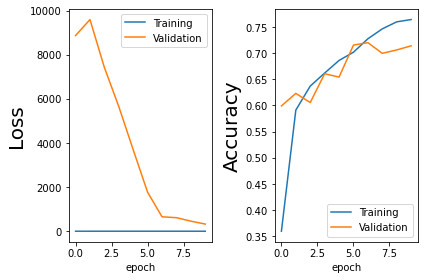

In [61]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.plot(Network.history['loss'],label='Train')
plt.plot(Network.history['val_loss'],label='Validation')
plt.ylabel('Loss',fontsize=20)
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='best')  # upper

plt.subplot(122)
plt.plot(Network.history['accuracy'],label='Train')
plt.plot(Network.history['val_accuracy'],label='Validation')
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='best')  # upper
plt.tight_layout()

plt.show()

In [62]:
# 24052021
Test_pred =model.predict(test_dataset)  
print(Test_pred.shape) 
print(Test_pred) 

(3, 5)
[[8.5131550e-01 1.7064700e-01 1.9618869e-03 4.1543335e-02 1.7090198e-01]
 [2.8704047e-02 6.8578720e-03 8.7423905e-05 2.1155831e-01 8.9126456e-01]
 [2.3843750e-01 7.5708330e-03 1.6421080e-04 7.6737821e-01 3.4872270e-01]]


In [63]:
Test_pred_round=Test_pred.round()
Test_pred_round 

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [64]:
df_test=pd.DataFrame(Test_pred_round, columns=['scab','rust','powdery_mildew','frog_eye_leaf_spot','complex'])
df_test

,scab,rust,powdery_mildew,frog_eye_leaf_spot,complex
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0


In [65]:
df_test['labels'] = df_test['scab'].apply(lambda x:'scab ' if x==1 else "") \
                        +  df_test['rust'].apply(lambda x:'rust ' if x==1 else "")  \
                        +   df_test['powdery_mildew'].apply(lambda x:'powdery_mildew ' if x==1 else "")  \
            + df_test['frog_eye_leaf_spot'].apply(lambda x:'frog_eye_leaf_spot ' if x==1 else "") \
            + df_test['complex'].apply(lambda x:'complex ' if x==1 else "") 
        
df_test['labels']= df_test['labels'].str.strip()
# print(df_test)
# df_test.drop(['healthy','scab','rust','powdery_mildew','frog_eye_leaf_spot','complex'], axis = 1, inplace = True)

test_data['labels'] = df_test['labels']
print(test_data)

                  image              labels
0  85f8cb619c66b863.jpg                scab
1  ad8770db05586b59.jpg             complex
2  c7b03e718489f3ca.jpg  frog_eye_leaf_spot


In [80]:
test_data.to_csv('submission.csv',index=False)